# Foundation - "Attention is all You Need" Paper

In [1]:
import torch.nn as nn
import numpy 
import torch 
import torch.nn.functional as F
import math, copy, re
import warnings 
warnings.simplefilter("ignore")
print(torch.__version__)

2.3.0+cpu


## Word Embedding 

Create a word embedding for the each word in a input sequence to change it to the embedding vector. Embedding vectors will create a more semantic representation of each word.

In [2]:
class Embedding(nn.Module):
    def __init__(self, vocab_size, embed_dim):
        """
        Args:
            vocab_size: size of vocabulary
            embed_dim: dimension of embeddings
        """
        super(Embedding, self).__init__()
        self.embed = nn.Embedding(vocab_size, embed_dim)
    def forward(self, x):
        """
        Args:
            x: input vector
        Returns:
            out: embedding vector
        """
        out = self.embed(x)
        return out

## Positional Encoding

Transformer model doesn't contain convlution or recurrence, so some information are injected about the relative and absolute position of the tokens in a sequence. Positional Encoding is added to the bottom of encoder and decoder stacks.

On odd time steps a `cosine` function is used and in even time steps a `sine` function is used.

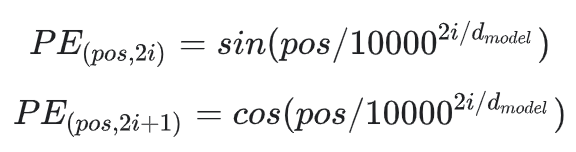

where `pos` is the position and `i` is the dimension.

Positinal embedding will generate a matrix of similar to embedding matrix.

Dimesnion of Matrix = sequence length x embedding Dimesion

if we have batch size of 32 and seq length of 10 and let embedding dimension be 512. Then we will have embedding vector of dimension 32 x 10 x 512. Similarly we will have positional encoding vector of dimension 32 x 10 x 512. Then we add both.

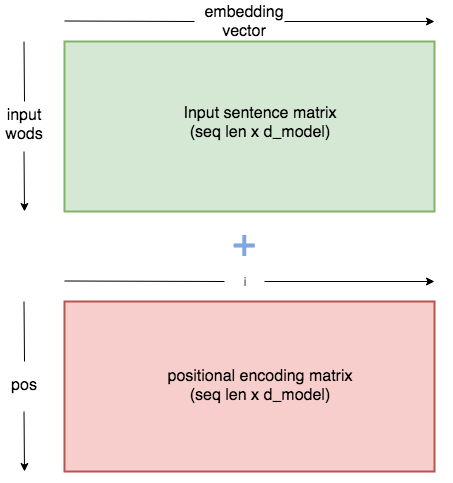

In [3]:
# register buffer in Pytorch ->
# If you have parameters in your model, which should be saved and restored in the state_dict,
# but not trained by the optimizer, you should register them as buffers.


class PositionalEmbedding(nn.Module):
    def __init__(self,max_seq_len,embed_model_dim):
        """
        Args:
            seq_len: length of input sequence
            embed_model_dim: demension of embedding
        """
        super(PositionalEmbedding, self).__init__()
        self.embed_dim = embed_model_dim

        pe = torch.zeros(max_seq_len,self.embed_dim)
        for pos in range(max_seq_len):
            for i in range(0,self.embed_dim,2):
                pe[pos, i] = math.sin(pos / (10000 ** ((2 * i)/self.embed_dim)))
                pe[pos, i + 1] = math.cos(pos / (10000 ** ((2 * (i + 1))/self.embed_dim)))
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)


    def forward(self, x):
        """
        Args:
            x: input vector
        Returns:
            x: output
        """
      
        # make embeddings relatively larger
        x = x * math.sqrt(self.embed_dim)
        #add constant to embedding
        seq_len = x.size(1)
        x = x + torch.autograd.Variable(self.pe[:,:seq_len], requires_grad=False)
        return x
               

## Attention

 The first step in calculating self-attention is to create three vectors from each of the encoder’s input vectors (in this case, the embedding of each word). So for each word, we create a Query vector, a Key vector, and a Value vector. Each of the vector will be of dimension 1x64.

 Suppose we have batch_size=32,sequence_length=10, embedding dimension=512. So after embedding and positional encoding our output will be of dimension 32x10x512.
We will `resize` it to 32x10x8x64.(About 8, it is the number of heads in multihead attention.


In [4]:
class MultiHeadAttention(nn.Module):
    def __init__(self, embed_dim=512, n_heads=8):
        """
        Args:
            embed_dim: dimension of embeding vector output
            n_heads: number of self attention heads
        """
        super(MultiHeadAttention, self).__init__()

        self.embed_dim = embed_dim    #512 dim
        self.n_heads = n_heads   #8
        self.single_head_dim = int(self.embed_dim / self.n_heads)   #512/8 = 64  . each key,query, value will be of 64d
       
        #key,query and value matrixes    #64 x 64   
        self.query_matrix = nn.Linear(self.single_head_dim , self.single_head_dim ,bias=False)  # single key matrix for all 8 keys #512x512
        self.key_matrix = nn.Linear(self.single_head_dim  , self.single_head_dim, bias=False)
        self.value_matrix = nn.Linear(self.single_head_dim ,self.single_head_dim , bias=False)
        self.out = nn.Linear(self.n_heads*self.single_head_dim ,self.embed_dim) 

    def forward(self,key,query,value,mask=None):    #batch_size x sequence_length x embedding_dim    # 32 x 10 x 512
        
        """
        Args:
           key : key vector
           query : query vector
           value : value vector
           mask: mask for decoder
        
        Returns:
           output vector from multihead attention
        """
        batch_size = key.size(0)
        seq_length = key.size(1)
        
        # query dimension can change in decoder during inference. 
        # so we cant take general seq_length
        seq_length_query = query.size(1)
        
        # 32x10x512
        key = key.view(batch_size, seq_length, self.n_heads, self.single_head_dim)  #batch_size x sequence_length x n_heads x single_head_dim = (32x10x8x64)
        query = query.view(batch_size, seq_length_query, self.n_heads, self.single_head_dim) #(32x10x8x64)
        value = value.view(batch_size, seq_length, self.n_heads, self.single_head_dim) #(32x10x8x64)
       
        k = self.key_matrix(key)       # (32x10x8x64)
        q = self.query_matrix(query)   
        v = self.value_matrix(value)

        q = q.transpose(1,2)  # (batch_size, n_heads, seq_len, single_head_dim)    # (32 x 8 x 10 x 64)
        k = k.transpose(1,2)  # (batch_size, n_heads, seq_len, single_head_dim)
        v = v.transpose(1,2)  # (batch_size, n_heads, seq_len, single_head_dim)
       
        # computes attention
        # adjust key for matrix multiplication
        k_adjusted = k.transpose(-1,-2)  #(batch_size, n_heads, single_head_dim, seq_ken)  #(32 x 8 x 64 x 10)
        product = torch.matmul(q, k_adjusted)  #(32 x 8 x 10 x 64) x (32 x 8 x 64 x 10) = #(32x8x10x10)
      
        
        # fill those positions of product matrix as (-1e20) where mask positions are 0
        if mask is not None:
             product = product.masked_fill(mask == 0, float("-1e20"))

        #divising by square root of key dimension
        product = product / math.sqrt(self.single_head_dim) # / sqrt(64)

        #applying softmax
        scores = F.softmax(product, dim=-1)
 
        #mutiply with value matrix
        scores = torch.matmul(scores, v)  ##(32x8x 10x 10) x (32 x 8 x 10 x 64) = (32 x 8 x 10 x 64) 
        
        #concatenated output
        concat = scores.transpose(1,2).contiguous().view(batch_size, seq_length_query, self.single_head_dim*self.n_heads)  # (32x8x10x64) -> (32x10x8x64)  -> (32,10,512)
        
        output = self.out(concat) #(32,10,512) -> (32,10,512)
       
        return output

In [5]:
class TransformerBlock(nn.Module):
    def __init__(self, embed_dim, expansion_factor=4, n_heads=8):
        super(TransformerBlock, self).__init__()
        
        """
        Args:
           embed_dim: dimension of the embedding
           expansion_factor: fator ehich determines output dimension of linear layer
           n_heads: number of attention heads
        
        """
        self.attention = MultiHeadAttention(embed_dim, n_heads)
        
        self.norm1 = nn.LayerNorm(embed_dim) 
        self.norm2 = nn.LayerNorm(embed_dim)
        
        self.feed_forward = nn.Sequential(
                          nn.Linear(embed_dim, expansion_factor*embed_dim),
                          nn.ReLU(),
                          nn.Linear(expansion_factor*embed_dim, embed_dim)
        )

        self.dropout1 = nn.Dropout(0.2)
        self.dropout2 = nn.Dropout(0.2)

    def forward(self,key,query,value):
        
        """
        Args:
           key: key vector
           query: query vector
           value: value vector
           norm2_out: output of transformer block
        
        """
        
        attention_out = self.attention(key,query,value)  #32x10x512
        attention_residual_out = attention_out + value  #32x10x512
        norm1_out = self.dropout1(self.norm1(attention_residual_out)) #32x10x512

        feed_fwd_out = self.feed_forward(norm1_out) #32x10x512 -> #32x10x2048 -> 32x10x512
        feed_fwd_residual_out = feed_fwd_out + norm1_out #32x10x512
        norm2_out = self.dropout2(self.norm2(feed_fwd_residual_out)) #32x10x512

        return norm2_out



class TransformerEncoder(nn.Module):
    """
    Args:
        seq_len : length of input sequence
        embed_dim: dimension of embedding
        num_layers: number of encoder layers
        expansion_factor: factor which determines number of linear layers in feed forward layer
        n_heads: number of heads in multihead attention
        
    Returns:
        out: output of the encoder
    """
    def __init__(self, seq_len, vocab_size, embed_dim, num_layers=2, expansion_factor=4, n_heads=8):
        super(TransformerEncoder, self).__init__()
        
        self.embedding_layer = Embedding(vocab_size, embed_dim)
        self.positional_encoder = PositionalEmbedding(seq_len, embed_dim)

        self.layers = nn.ModuleList([TransformerBlock(embed_dim, expansion_factor, n_heads) for i in range(num_layers)])
    
    def forward(self, x):
        embed_out = self.embedding_layer(x)
        out = self.positional_encoder(embed_out)
        for layer in self.layers:
            out = layer(out,out,out)

        return out  #32x10x512

In [6]:
class DecoderBlock(nn.Module):
    def __init__(self, embed_dim, expansion_factor=4, n_heads=8):
        super(DecoderBlock, self).__init__()

        """
        Args:
           embed_dim: dimension of the embedding
           expansion_factor: fator ehich determines output dimension of linear layer
           n_heads: number of attention heads
        
        """
        self.attention = MultiHeadAttention(embed_dim, n_heads=8)
        self.norm = nn.LayerNorm(embed_dim)
        self.dropout = nn.Dropout(0.2)
        self.transformer_block = TransformerBlock(embed_dim, expansion_factor, n_heads)
        
    
    def forward(self, key, query, x,mask):
        
        """
        Args:
           key: key vector
           query: query vector
           value: value vector
           mask: mask to be given for multi head attention 
        Returns:
           out: output of transformer block
    
        """
        
        #we need to pass mask mask only to fst attention
        attention = self.attention(x,x,x,mask=mask) #32x10x512
        value = self.dropout(self.norm(attention + x))
        
        out = self.transformer_block(key, query, value)

        
        return out


class TransformerDecoder(nn.Module):
    def __init__(self, target_vocab_size, embed_dim, seq_len, num_layers=2, expansion_factor=4, n_heads=8):
        super(TransformerDecoder, self).__init__()
        """  
        Args:
           target_vocab_size: vocabulary size of taget
           embed_dim: dimension of embedding
           seq_len : length of input sequence
           num_layers: number of encoder layers
           expansion_factor: factor which determines number of linear layers in feed forward layer
           n_heads: number of heads in multihead attention
        
        """
        self.word_embedding = nn.Embedding(target_vocab_size, embed_dim)
        self.position_embedding = PositionalEmbedding(seq_len, embed_dim)

        self.layers = nn.ModuleList(
            [
                DecoderBlock(embed_dim, expansion_factor=4, n_heads=8) 
                for _ in range(num_layers)
            ]

        )
        self.fc_out = nn.Linear(embed_dim, target_vocab_size)
        self.dropout = nn.Dropout(0.2)

    def forward(self, x, enc_out, mask):
        
        """
        Args:
            x: input vector from target
            enc_out : output from encoder layer
            trg_mask: mask for decoder self attention
        Returns:
            out: output vector
        """
            
        
        x = self.word_embedding(x)  #32x10x512
        x = self.position_embedding(x) #32x10x512
        x = self.dropout(x)
     
        for layer in self.layers:
            x = layer(enc_out, x, enc_out, mask) 

        out = F.softmax(self.fc_out(x))

        return out

In [7]:
class Transformer(nn.Module):
    def __init__(self, embed_dim, src_vocab_size, target_vocab_size, seq_length,num_layers=2, expansion_factor=4, n_heads=8):
        super(Transformer, self).__init__()
        
        """  
        Args:
           embed_dim:  dimension of embedding 
           src_vocab_size: vocabulary size of source
           target_vocab_size: vocabulary size of target
           seq_length : length of input sequence
           num_layers: number of encoder layers
           expansion_factor: factor which determines number of linear layers in feed forward layer
           n_heads: number of heads in multihead attention
        
        """
        
        self.target_vocab_size = target_vocab_size

        self.encoder = TransformerEncoder(seq_length, src_vocab_size, embed_dim, num_layers=num_layers, expansion_factor=expansion_factor, n_heads=n_heads)
        self.decoder = TransformerDecoder(target_vocab_size, embed_dim, seq_length, num_layers=num_layers, expansion_factor=expansion_factor, n_heads=n_heads)
        
    
    def make_trg_mask(self, trg):
        """
        Args:
            trg: target sequence
        Returns:
            trg_mask: target mask
        """
        batch_size, trg_len = trg.shape
        # returns the lower triangular part of matrix filled with ones
        trg_mask = torch.tril(torch.ones((trg_len, trg_len))).expand(
            batch_size, 1, trg_len, trg_len
        )
        return trg_mask    

    def decode(self,src,trg):
        """
        for inference
        Args:
            src: input to encoder 
            trg: input to decoder
        out:
            out_labels : returns final prediction of sequence
        """
        trg_mask = self.make_trg_mask(trg)
        enc_out = self.encoder(src)
        out_labels = []
        batch_size,seq_len = src.shape[0],src.shape[1]
        #outputs = torch.zeros(seq_len, batch_size, self.target_vocab_size)
        out = trg
        for i in range(seq_len): #10
            out = self.decoder(out,enc_out,trg_mask) #bs x seq_len x vocab_dim
            # taking the last token
            out = out[:,-1,:]
     
            out = out.argmax(-1)
            out_labels.append(out.item())
            out = torch.unsqueeze(out,axis=0)
          
        
        return out_labels
    
    def forward(self, src, trg):
        """
        Args:
            src: input to encoder 
            trg: input to decoder
        out:
            out: final vector which returns probabilities of each target word
        """
        trg_mask = self.make_trg_mask(trg)
        enc_out = self.encoder(src)
   
        outputs = self.decoder(trg, enc_out, trg_mask)
        return outputs

In [8]:
src_vocab_size = 11
target_vocab_size = 11
num_layers = 6
seq_length= 12


# let 0 be sos token and 1 be eos token
src = torch.tensor([[0, 2, 5, 6, 4, 3, 9, 5, 2, 9, 10, 1], 
                    [0, 2, 8, 7, 3, 4, 5, 6, 7, 2, 10, 1]])
target = torch.tensor([[0, 1, 7, 4, 3, 5, 9, 2, 8, 10, 9, 1], 
                       [0, 1, 5, 6, 2, 4, 7, 6, 2, 8, 10, 1]])

print(src.shape,target.shape)
model = Transformer(embed_dim=512, src_vocab_size=src_vocab_size, 
                    target_vocab_size=target_vocab_size, seq_length=seq_length,
                    num_layers=num_layers, expansion_factor=4, n_heads=8)
model

torch.Size([2, 12]) torch.Size([2, 12])


Transformer(
  (encoder): TransformerEncoder(
    (embedding_layer): Embedding(
      (embed): Embedding(11, 512)
    )
    (positional_encoder): PositionalEmbedding()
    (layers): ModuleList(
      (0-5): 6 x TransformerBlock(
        (attention): MultiHeadAttention(
          (query_matrix): Linear(in_features=64, out_features=64, bias=False)
          (key_matrix): Linear(in_features=64, out_features=64, bias=False)
          (value_matrix): Linear(in_features=64, out_features=64, bias=False)
          (out): Linear(in_features=512, out_features=512, bias=True)
        )
        (norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (feed_forward): Sequential(
          (0): Linear(in_features=512, out_features=2048, bias=True)
          (1): ReLU()
          (2): Linear(in_features=2048, out_features=512, bias=True)
        )
        (dropout1): Dropout(p=0.2, inplace=False)
        (dropout2): 

In [10]:
class MultiHeadAttention1(nn.Module):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention1, self).__init__()
        assert d_model % num_heads == 0, "d_model must be divisible by num_heads"

        self.d_model = d_model
        self.num_heads = num_heads
        self.d_k = d_model//num_heads

        self.W_q = nn.Linear(d_model, d_model)
        self.W_k = nn.Linear(d_model, d_model)
        self.W_v = nn.Linear(d_model, d_model)
        self.W_o = nn.Linear(d_model, d_model)

        def scaled_dot_product(self, K, Q, V, mask = None):
            attn_scores = torch.matmul(Q, K.transpose(-2,-1))/math.sqrt(self.d_k)
            if mask is not None:
                attn_scores = attn_scores.masked_fill(mask==0, float("-1e20"))
            attn_scores = torch.softmax(attn_scores)
            output = torch.matmul(attn_scores, V)
            return output
        
        def split_heads(self, x):
            batch_size, seq_length, d_model = x.size()
            return x.view(batch_size, seq_length, self.num_heads, self.d_k).transpose(1, 2)
        
        def combine_heads(self, x):
            batch_size, _, seq_length, d_k = x.size()
            return x.transpose(1, 2).contiguous().view(batch_size, seq_length, self.d_model)
        
        def forward(self, K, Q, V, mask=None):
            K = self.split_heads(self.W_k(K))
            Q = self.split_heads(self.W_k(Q))
            V = self.split_heads(self.W_k(V))

            scaled = scaled_dot_product(K,Q,V,mask)
            output = self.W_o(self.combine_heads(scaled))
            return output

In [11]:
class PositionwiseFeedForwardNetworks(nn.Module):
    def __init__(self, d_model, d_ff):
        super(PositionwiseFeedForwardNetworks, self).__init__()

        self.fc1 = nn.Linear(d_model, d_ff)
        self.fc2 = nn.Linear(d_ff, d_model)
        self.relu = nn.ReLU()

        def forward(self, x):
            return self.fc2(self.relu(self.fc1(x)))

In [12]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_seq_length):
        super(PositionalEncoding, self).__init__()

        pe = torch.zeros(max_seq_length, d_model)
        for pos in range(max_seq_length):
            for j in range(0, max_seq_length, 2):
                pe[pos, j] = math.sin(pos/ 10000**((2*j)/d_model))
                if j+1<d_model:
                    pe[pos, j+1] = math.cos(pos/ 10000**(2*(j+1)/d_model))

        pe = pe.unsqueeze(0)

        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x * math.sqrt(self.d_model)
        #add constant to embedding
        seq_len = x.size(1)
        x = x + torch.autograd.Variable(self.pe[:,:seq_len], requires_grad=False)
        return x


In [24]:
class EncoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, dropout):
        super(EncoderLayer, self).__init__()

        self.attn_scores = MultiHeadAttention1(d_model, num_heads)
        self.feedforward = PositionwiseFeedForwardNetworks(d_model, d_ff)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)


    def forward(self, x, mask):
        attn_output = self.attn_score(x, x, x, mask)
        x = self.norm1(x + self.dropout(attn_output))
        attn_output = self.feedforward(x)
        x = self.norm2(x + self.dropout(attn_output))
        return x

In [25]:
class DecoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, dropout):
        super(DecoderLayer, self).__init__()
        self.self_attn = MultiHeadAttention1(d_model, num_heads)
        self.cross_attn = MultiHeadAttention1(d_model, num_heads)
        self.feedforward = PositionwiseFeedForwardNetworks(d_model, d_ff)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.norm3 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, erc_output, src_mask, tgt_mask):
        attn_output = self.self_attn(x,x,x,tgt_mask)
        x = self.norm1(x + self.dropout(attn_output))
        attn_output = self.cross_attn(x, erc_output, erc_output,src_mask)
        x = self.norm2(x + self.dropout(attn_output))
        ff_output = self.feedforward(x)
        x = self.norm3(x + self.dropout(ff_output))
        return x

In [26]:
class Embedding(nn.Module):
    def __init__(self, vocab_size, embed_dim):
        """
        Args:
            vocab_size: size of vocabulary
            embed_dim: dimension of embeddings
        """
        super(Embedding, self).__init__()
        self.embed = nn.Embedding(vocab_size, embed_dim)
    def forward(self, x):
        """
        Args:
            x: input vector
        Returns:
            out: embedding vector
        """
        out = self.embed(x)
        return out

In [27]:
class Transformer(nn.Module):
    def __init__(self, src_vocab_size, target_vocab_size, d_model, num_heads, n_layers, d_ff, max_seq_length, dropout):
        super(Transformer, self).__init__()
        self.encoder_embedding = nn.Embedding(src_vocab_size, d_model)
        self.decoder_embedding = nn.Embedding(tgt_vocab_size, d_model)
        self.positional_encoding = PositionalEncoding(d_model, max_seq_length)
        self.encoder_layers = nn.ModuleList([EncoderLayer(d_model, num_heads, d_ff, dropout) for _ in range(num_layers)])
        self.decoder_layers = nn.ModuleList([DecoderLayer(d_model, num_heads, d_ff, dropout) for _ in range(num_layers)])

        self.fc = nn.Linear(d_model, tgt_vocab_size)
        self.dropout = nn.Dropout(dropout)

        def generate_mask(self, src, tgt):
            src_mask = (src != 0).unsqueeze(1).unsqueeze(2)
            tgt_mask = (tgt != 0).unsqueeze(1).unsqueeze(3)
            seq_length = tgt.size(1)
            nopeak_mask = (1 - torch.triu(torch.ones(1, seq_length, seq_length), diagonal=1)).bool()
            tgt_mask = tgt_mask & nopeak_mask
            return src_mask, tgt_mask

        def forward(self, src, tgt):
            src_mask, tgt_mask = self.generate_mask(src, tgt)
            src_embedded = self.dropout(self.positional_encoding(self.encoder_embedding(src)))
            tgt_embedded = self.dropout(self.positional_encoding(self.decoder_embedding(tgt)))

            enc_output = src_embedded
            for enc_layer in self.encoder_layers:
                enc_output = enc_layer(enc_output, src_mask)

            dec_output = tgt_embedded
            for dec_layer in self.decoder_layers:
                dec_output = dec_layer(dec_output, enc_output, src_mask, tgt_mask)

            output = self.fc(dec_output)
            return output

In [28]:
src_vocab_size = 5000
tgt_vocab_size = 5000
d_model = 512
num_heads = 8
num_layers = 6
d_ff = 2048
max_seq_length = 100
dropout = 0.1

transformer = Transformer(src_vocab_size, tgt_vocab_size, d_model, num_heads, num_layers, d_ff, max_seq_length, dropout)

# Generate random sample data
src_data = torch.randint(1, src_vocab_size, (64, max_seq_length))  # (batch_size, seq_length)
tgt_data = torch.randint(1, tgt_vocab_size, (64, max_seq_length))  # (batch_size, seq_length)

print(transformer)

Transformer(
  (encoder_embedding): Embedding(5000, 512)
  (decoder_embedding): Embedding(5000, 512)
  (positional_encoding): PositionalEncoding()
  (encoder_layers): ModuleList(
    (0-5): 6 x EncoderLayer(
      (attn_scores): MultiHeadAttention1(
        (W_q): Linear(in_features=512, out_features=512, bias=True)
        (W_k): Linear(in_features=512, out_features=512, bias=True)
        (W_v): Linear(in_features=512, out_features=512, bias=True)
        (W_o): Linear(in_features=512, out_features=512, bias=True)
      )
      (feedforward): PositionwiseFeedForwardNetworks(
        (fc1): Linear(in_features=512, out_features=2048, bias=True)
        (fc2): Linear(in_features=2048, out_features=512, bias=True)
        (relu): ReLU()
      )
      (norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (norm2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
  )
  (decoder_layers): ModuleList(
    (0-5): 6 x Decod